In [14]:

#install.packages("httpgd")

In [15]:
library(tidyverse)
library(xts)
library(zoo)
library(svglite)
library(TSstudio)
library(zoo)
library(dlm)
library(forecast)
library(expsmooth)
library(ggplot2)
library(ggfortify)
library(changepoint)
library(KFAS)
library(httpgd)

# Time series plots
# https://cran.rstudio.com/web/packages/ggfortify/vignettes/plot_ts.html

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2000,79.0,80.3,87.3,80.9,81.7,82.5,85.2,77.2,80.5,91.6,95.2,104.9
2001,86.6,82.2,95.2,86.9,91.1,90.4,88.5,81.9,85.1,105.3,102.1,106.5
2002,91.7,86.5,91.8,87.8,91.3,86.6,90.2,80.4,80.8,97.2,96.2,100.1
2003,91.0,84.6,87.4,84.9,86.1,77.9,83.4,71.7,79.3,92.2,85.6,96.6
2004,87.1,78.9,89.1,80.7,78.9,80.1,84.4,70.7,79.1,87.7,86.7,95.9
2005,83.1,78.0,86.3,80.1,78.6,79.3,82.5,76.0,80.7,91.1,92.2,101.3
2006,90.4,83.1,96.3,86.4,90.5,87.8,78.9,88.6,86.3,96.4,96.5,102.9
2007,95.7,87.5,98.5,84.5,93.4,92.3,92.9,88.9,89.5,101.0,99.0,103.5
2008,96.3,90.8,96.6,94.6,92.3,88.9,95.9,89.2,88.3,101.7,93.2,99.1
2009,91.5,83.7,89.4,84.4,83.6,82.1,88.7,77.3,81.3,94.4,86.1,94.6


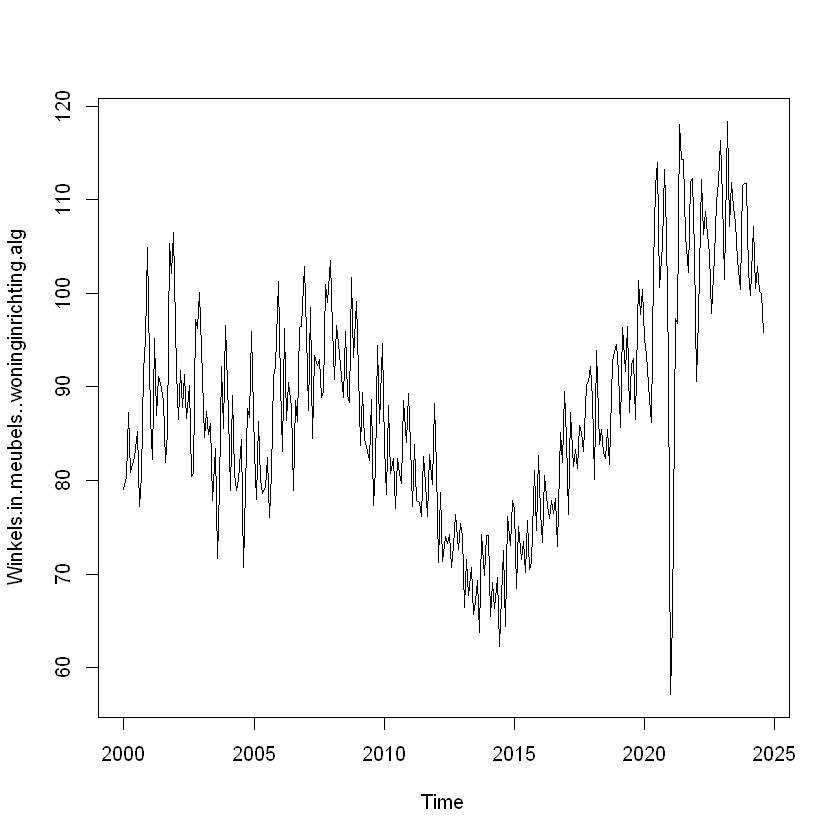

In [16]:
##########################
# First smooth, if data is missing from the original "y" series, replace it
# Only take values from 2005 Q1 to 2024Q1

# load data
dt1 <- read.csv("../data/HandelDiensten_raw.csv", sep = ",")
series1 <- ts(dt1["Winkels.in.meubels..woninginrichting.alg"], frequency = 12, start=c(2000,1))

plot.ts(series1)
series1

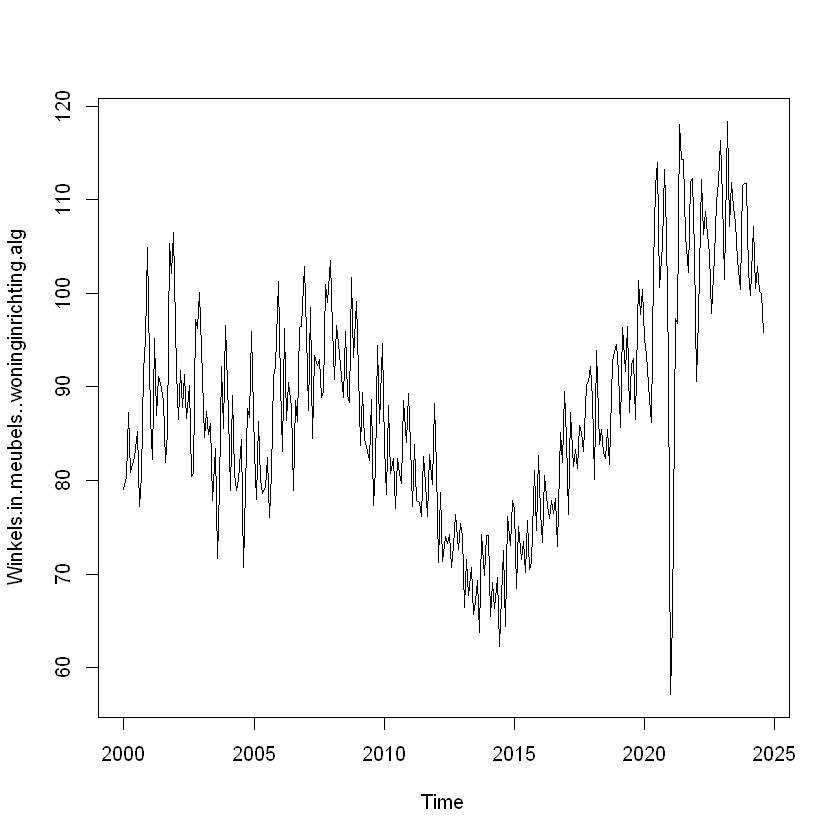

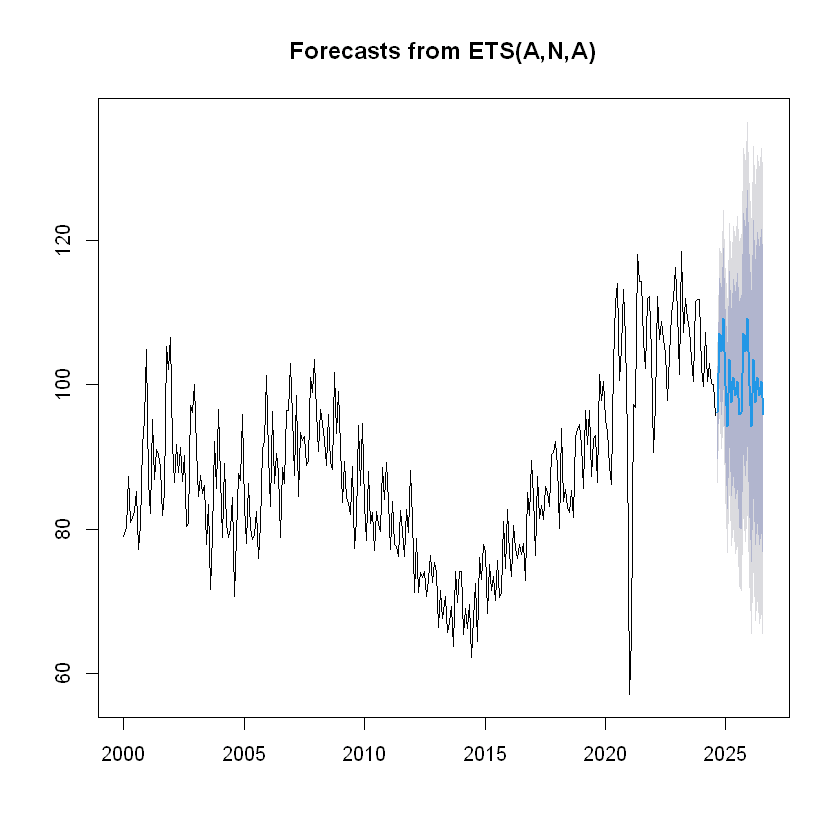

In [17]:
plot(series1)
#ets(bonds, model="AAN", damped=TRUE)
#ets(usnetelec, model="MMN",damped=TRUE)
#ets(ukcars, model="ANA")
#ets(visitors, model="MAM")

fit <- ets(series1, model="ANA", damped=FALSE)
plot(forecast(fit))

In [19]:
forecast(fit)

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Sep 2024       96.10789 89.68562 102.5302 86.28588 105.9299
Oct 2024      107.17511 99.45034 114.8999 95.36109 118.9891
Nov 2024      104.61236 95.77500 113.4497 91.09678 118.1279
Dec 2024      109.22961 99.40487 119.0544 94.20396 124.2553
Jan 2025       99.91416 89.19258 110.6357 83.51692 116.3114
Feb 2025       94.28109 82.73211 105.8301 76.61845 111.9437
Mar 2025      103.58050 91.25956 115.9014 84.73724 122.4238
Apr 2025       97.55419 84.50688 110.6015 77.60005 117.5083
May 2025      100.99249 87.25717 114.7278 79.98613 121.9989
Jun 2025       98.51803 84.12755 112.9085 76.50970 120.5264
Jul 2025      100.53118 85.51411 115.5483 77.56455 123.4978
Aug 2025       95.93469 80.31219 111.5572 72.04214 119.8272
Sep 2025       96.10789 79.90637 112.3094 71.32981 120.8860
Oct 2025      107.17511 90.41457 123.9357 81.54208 132.8082
Nov 2025      104.61236 87.31084 121.9139 78.15197 131.0727
Dec 2025      109.22961 91.40353 127.055

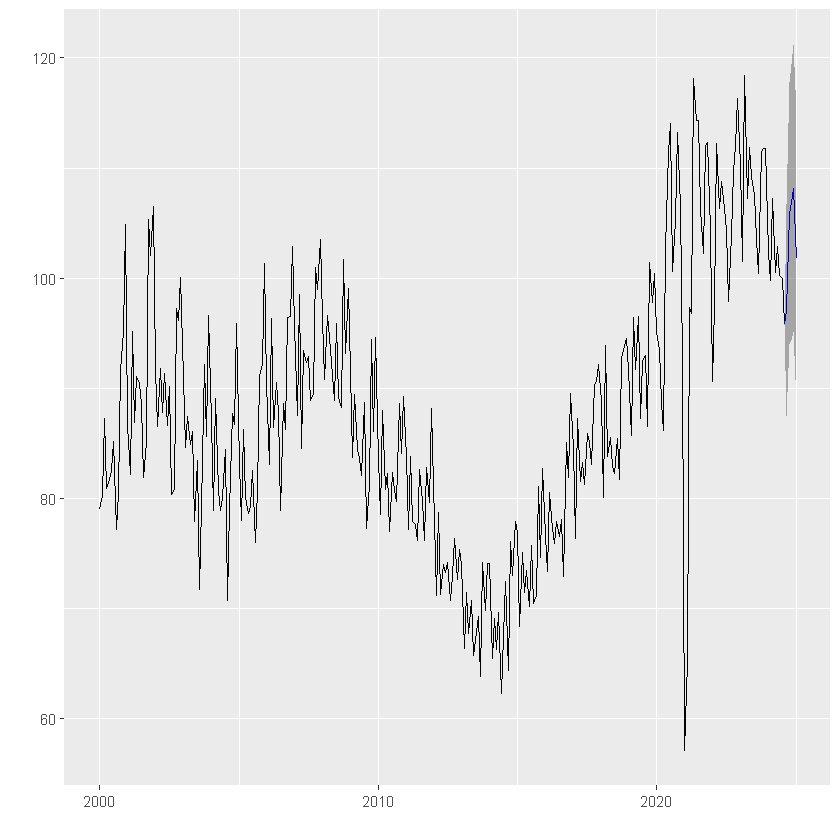

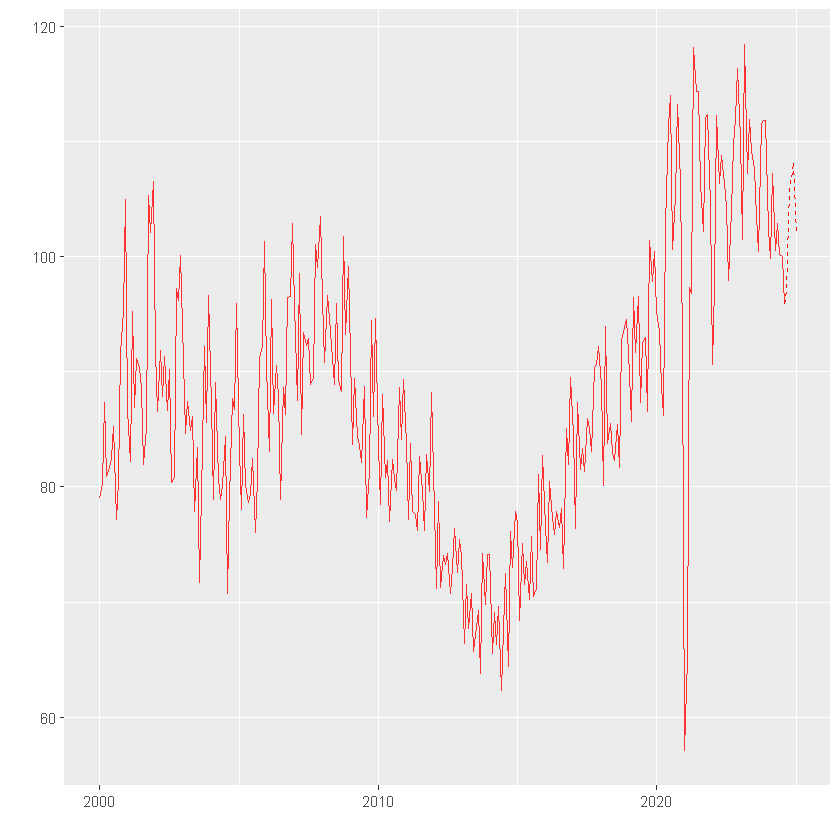

In [4]:
d.arima <- auto.arima(series1)
d.forecast <- forecast(d.arima, level = c(95), h = 5)
autoplot(d.forecast)

autoplot(d.forecast, ts.colour = 'firebrick1', predict.colour = 'red',
predict.linetype = 'dashed', conf.int = FALSE)

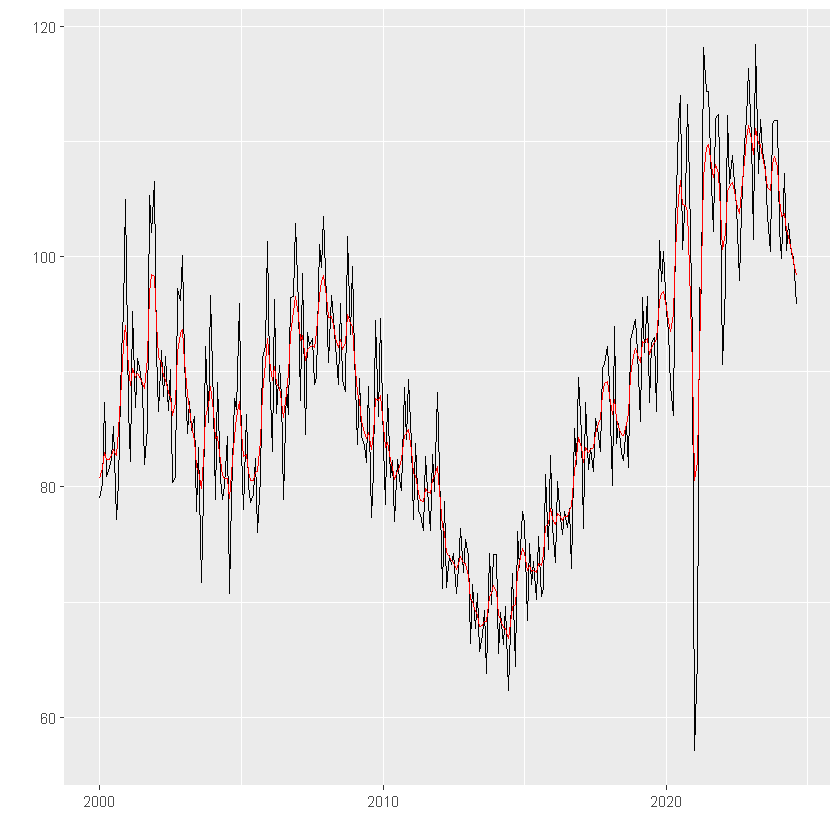

In [5]:
model <- SSModel(series1 ~ SSMtrend(degree=1, Q=matrix(NA)), H=matrix(NA))
 
fit <- fitSSM(model=model, inits=c(log(var(series1)),log(var(series1))), method="BFGS")
smoothed <- KFS(fit$model)
autoplot(smoothed)

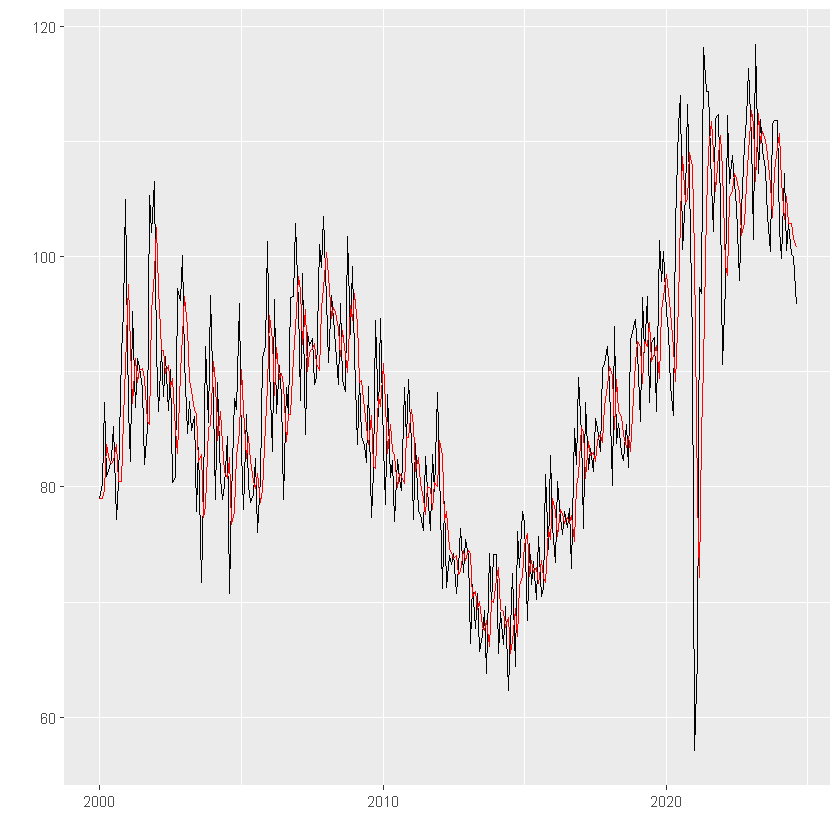

In [6]:
filtered <- KFS(fit$model, filtering="mean", smoothing='none')
autoplot(filtered)

In [8]:
trend <- signal(smoothed, states="trend")
class(trend)

[1] "list"

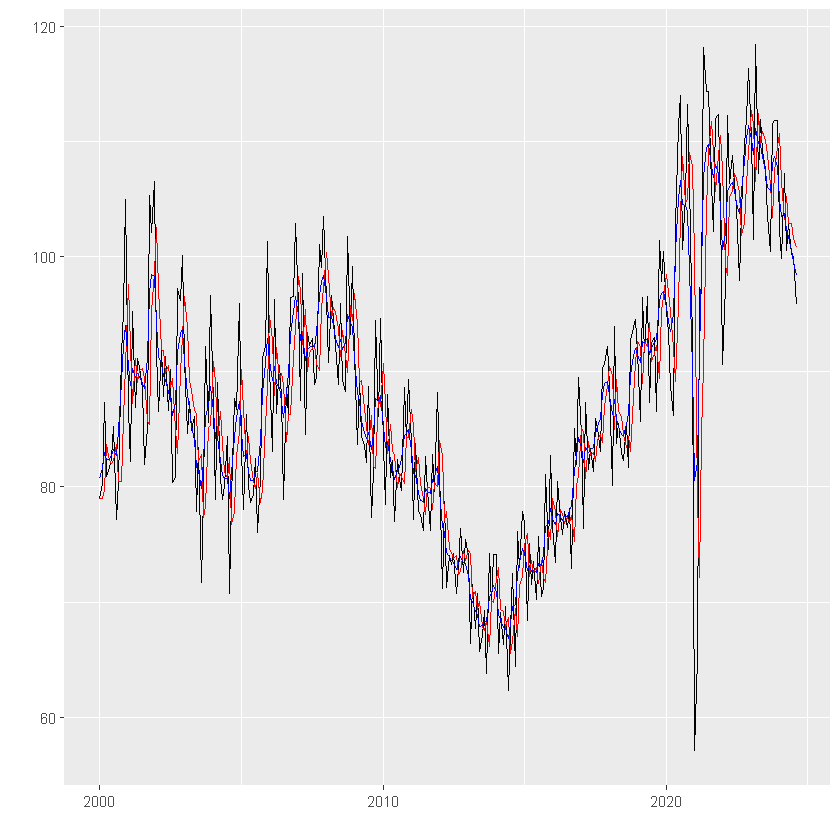

In [9]:
p <- autoplot(filtered)
autoplot(trend, ts.colour = 'blue', p = p)

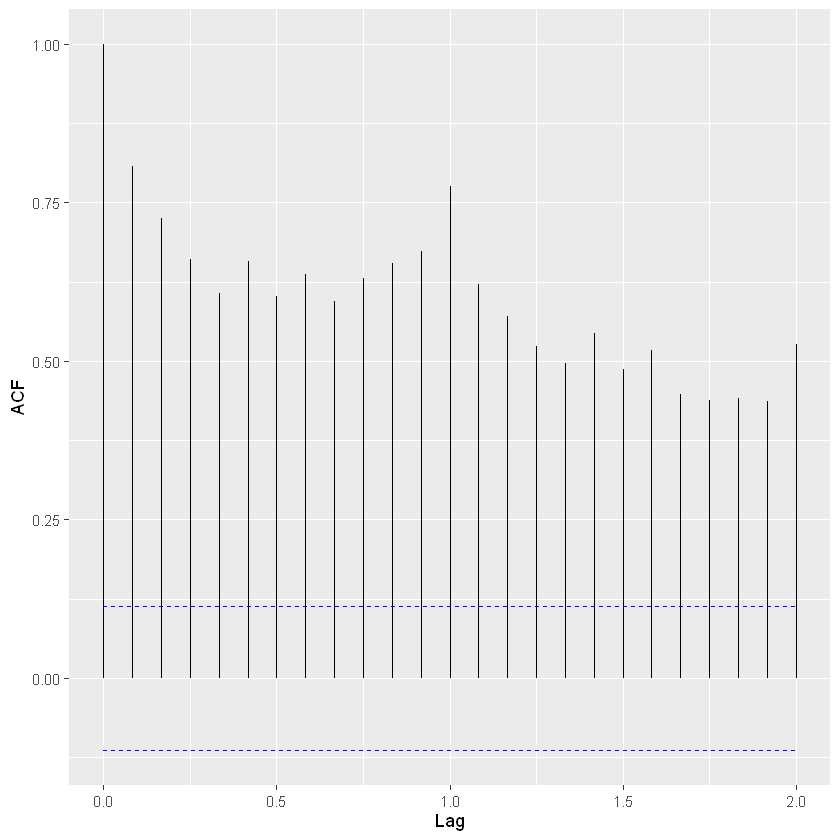

In [10]:
autoplot(acf(series1, plot = FALSE))

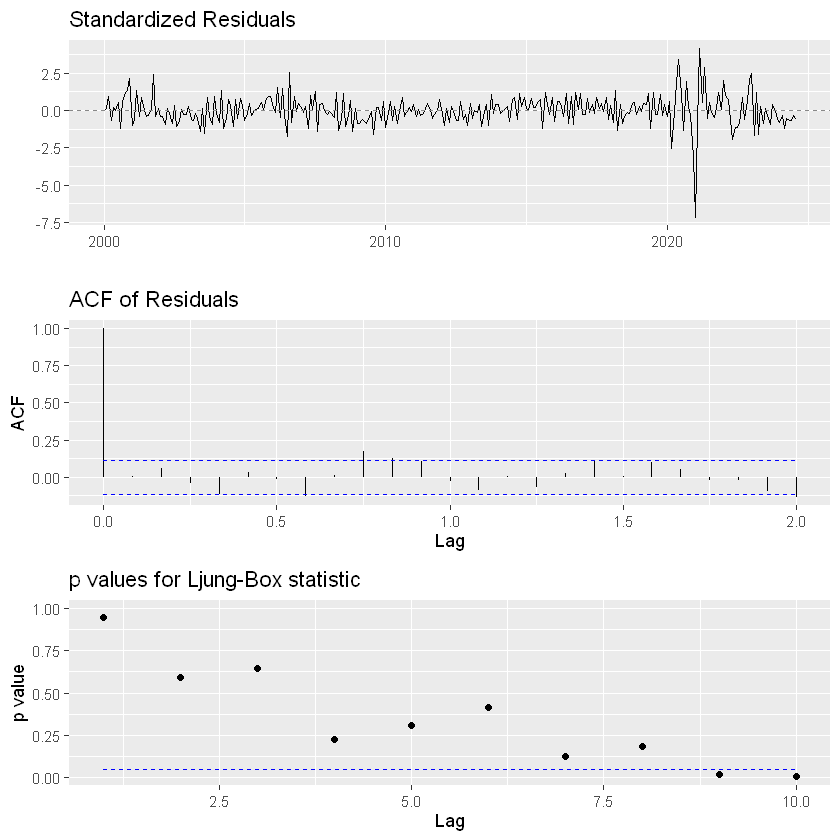

In [11]:
ggtsdiag(auto.arima(series1))

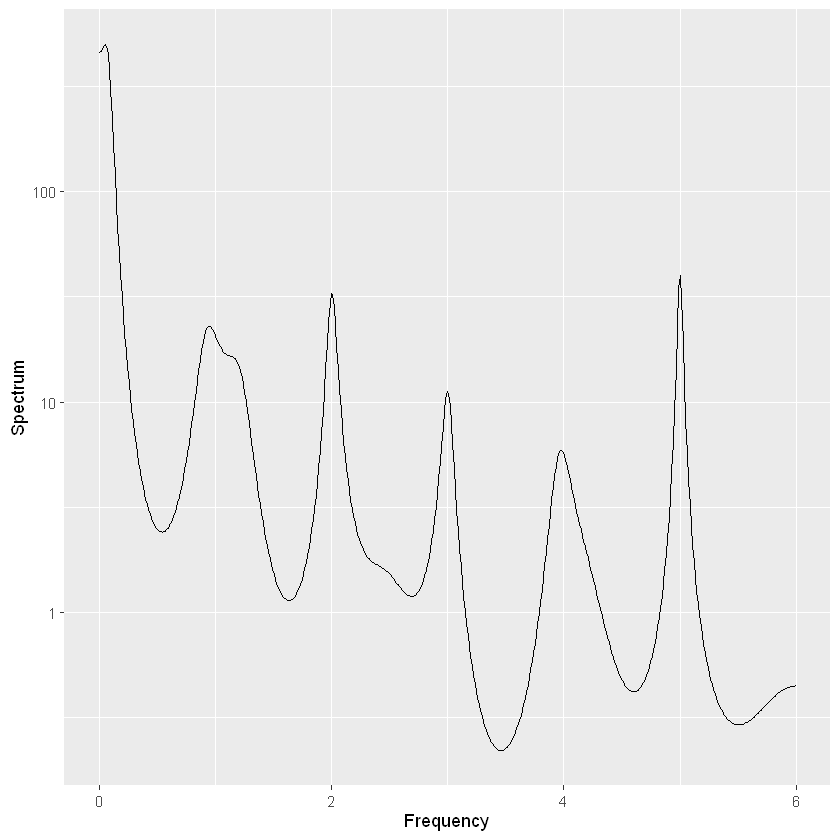

In [12]:
autoplot(spec.ar(series1, plot = FALSE))

In [10]:
ts2csv <- function(x) {
  fname <- paste0(deparse(substitute(x)), ".csv")
  readr::write_csv(tsibble::as_tsibble(x, gather(FALSE)), fname)
}

In [11]:
ts2csv(series1)

In [13]:

##### Start at 2005-01-01, replace missing values with best guess
dt2 <- dt1[-c(1:20), -c(1)]

# number columns
numColumns <- dim(dt2)[2]
numRows <- dim(dt2[1])
colNames <- colnames(dt2)

emptyDF = data.frame(matrix(NA, nrow = numRows, ncol = numColumns))
colnames(emptyDF) <- colnames(dt2)

In [14]:
for (i in 1:numColumns) {
    print(i)
    y <- dt2[, i]

    # ######################################
    # # Kalman smoothing
    # ######################################

    # Setting of local-level model
    W <- 1
    V <- 2
    m0 <- 10
    C0 <- 9
    mod <- dlmModPoly(order = 1, dW = W, dV = V, m0 = m0, C0 = C0)

    dlmSmoothed_obj <- dlmSmooth(y = y, mod = mod)

    # Find the mean and standard deviation of the smoothing distribution
    s <- dropFirst(dlmSmoothed_obj$s)

    # which of the original data is missing, for example, sector: 11_Drankenindustrie
    replaceThese <- which(is.na(y))
    y[replaceThese] <- s[replaceThese]

    emptyDF[,i] <- y
}    

write.csv(emptyDF, "tmp.csv")


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61


: 

In [ ]:
######################################
## Local-trend model
######################################

localTrend <- emptyDF

## Seasonal model
### Approach from the time domain
### Approach from the frequency domain
#### Local-trend model + seasonal model (time-domain approach)

# Preprocessing
library(dlm)

####
# Save forecasts
####
forecasts <- c()
namesCols <- c()

for (j in 0:18){
  png(paste("../output/Kalman2/plot_", j, ".png", sep = ""))
  par(mfrow = c(4, 1), mar = c(4, 1, 1, 4))

  begin <- 1 + (j * 4)
  end   <- 4 + (j * 4)

  if (begin <= 70) {

    for (i in begin:end){
      print(colNames[i])      
      mymain <- colNames[i]

      # Data
      y <- ts(na.omit(localTrend[, i]), frequency = 4, start = c(2005, 1))
      # if (colNames[i] == "X51_Vervoer_door_de_lucht"){
      #   print(y)
      #   print(!is.na(as.numeric(y)))
      # }

      # Model setting: local-trend model + seasonal model (time-domain approach)
      build_dlm_test <- function(par) {
        return(
          dlmModPoly(order = 2, dW = exp(par[1:2]), dV = exp(par[3])) +
          dlmModSeas(frequency = 4, dW = c(exp(par[4]), rep(0, times = 2)), dV = 1)
        )
      }

      # Maximum likelihood estimation of parameters and confirmation of the results
      fit_dlm_test <- dlmMLE(y = y, parm = rep(0, 4), build = build_dlm_test)
    
      # Set the maximum likelihood estimates of parameters in the model
      mod  <- build_dlm_test(fit_dlm_test$par)

      # # Kalman filtering
      dlmFiltered_obj  <- dlmFilter(y = y, mod = mod)
      dlmFiltered_obja <- dlmFiltered_obj  # Save under a different name for later comparison of prediction values

      ######################################
      # Kalman prediction
      ######################################

      dlmForecasted_object <- dlmForecast(mod = dlmFiltered_obj, nAhead = 8)
      forecasts[i] <- as.data.frame(dlmForecasted_object$f)

      # Find the standard deviation and the 2.5% and 97.5% values of the prediction value
      f_sd <- sqrt(as.numeric(dlmForecasted_object$Q))
      f_lower <- dlmForecasted_object$f + qnorm(0.025, sd = f_sd)
      f_upper <- dlmForecasted_object$f + qnorm(0.975, sd = f_sd)

      # Unite the entire observation along with the mean, 2.5%, and 97.5% values of the prediction values into ts class object
      y_union <- ts.union(y, dlmForecasted_object$f, f_lower, f_upper)

      # Plot results
      plot(y_union, plot.type = "single",
          xlim = c(2005, 2026),
          ylim = c(50,  240), ylab = "Year-Quarter", 
          lty = c("solid", "solid", "dashed", "dashed"),
          col = c("lightgray", "red", "black", "black"),
          main = mymain)

      # Legend
      legend(legend = c("Observations", "Mean (predictive distribution)", "95% intervals (predictive distribution)"),
            lty = c("solid", "solid", "dashed"),
            col = c("lightgray", "black", "black"),
            x = "topleft", cex = 0.6)

      # Grid
      grid(nx = NULL, ny = NULL,
          lty = 2,      # Grid line type
          col = "gray", # Grid line color
          lwd = 1)      # Grid line width
    }

    dev.off()
  
  } else {

    for (i in 71:75){

      print(colNames[i])
      if (length(na.omit(localTrend[, i])) < 20) next
      mymain <- colNames[i]

      # Data
      y <- ts(na.omit(localTrend[, i]), frequency = 4, start = c(2005, 1))

      # Model setting: local-trend model + seasonal model (time-domain approach)
      build_dlm_test <- function(par) {
        return(
          dlmModPoly(order = 2, dW = exp(par[1:2]), dV = exp(par[3])) +
          dlmModSeas(frequency = 4, dW = c(exp(par[4]), rep(0, times = 2)), dV = 0)
        )
      }

      # Maximum likelihood estimation of parameters and confirmation of the results
      fit_dlm_test <- dlmMLE(y = y, parm = rep(0, 4), build = build_dlm_test)
      fit_dlm_test

      # Set the maximum likelihood estimates of parameters in the model
      mod  <- build_dlm_test(fit_dlm_test$par)

      # # Kalman filtering
      dlmFiltered_obj  <- dlmFilter(y = y, mod = mod)
      dlmFiltered_obja <- dlmFiltered_obj  # Save under a different name for later comparison of prediction values

      ######################################
      # Kalman prediction
      ######################################

      dlmForecasted_object <- dlmForecast(mod = dlmFiltered_obj, nAhead = 4)
      forecasts[i] <-  as.data.frame(dlmForecasted_object$f)

      # Find the standard deviation and the 2.5% and 97.5% values of the prediction value
      f_sd <- sqrt(as.numeric(dlmForecasted_object$Q))
      f_lower <- dlmForecasted_object$f + qnorm(0.025, sd = f_sd)
      f_upper <- dlmForecasted_object$f + qnorm(0.975, sd = f_sd)

      # Unite the entire observation along with the mean, 2.5%, and 97.5% values of the prediction values into ts class object
      y_union <- ts.union(y, dlmForecasted_object$f, f_lower, f_upper)

      # Ignore the display of following codes

      # Plot results
      plot(y_union, plot.type = "single",
          xlim = c(2005, 2026),
          ylim = c(50,  240), ylab = "Year-Quarter", 
          lty = c("solid", "solid", "dashed", "dashed"),
          col = c("lightgray", "red", "black", "black"),
          main = mymain)

      # Legend
      legend(legend = c("Observations", "Mean (predictive distribution)", "95% intervals (predictive distribution)"),
            lty = c("solid", "solid", "dashed"),
            col = c("lightgray", "red", "black"),
            x = "topleft", cex = 0.6)

      # Grid
      grid(nx = NULL, ny = NULL,
          lty = 2,      # Grid line type
          col = "gray", # Grid line color
          lwd = 1)      # Grid line width

    }
    dev.off()
  }
}



[1] "X45.Autohandel.en..reparatie"
[1] "X451.Autohandel.en..reparatie"
[1] "X45111.Import.van.nieuwe.personenauto.s"
[1] "X452.Gespecialiseerde.autoreparatie"
[1] "X453.Handel.in.auto.onderdelen"
[1] "X454.Handel.en.reparatie.van.motorfietsen"
[1] "X46.Groothandel.en.handelsbemiddeling"
[1] "X462.Groothandel.in.landbouwproducten"
[1] "X463.Groothandel.in.voedingsmiddelen"
[1] "X464.Groothandel.in.non.food"
[1] "X466.Groothandel.in.industriemachines"
[1] "X467.Overige.gespecialiseerde.groothandel"
[1] "X47.Detailhandel..niet.in.auto.s."
[1] "X471.Supermarkten.en.warenhuizen"
[1] "X4711.Supermarkten"
[1] "X4711..472.Winkels.in.voedingsmiddelen"
[1] "X472.Winkels.in.voedingsmiddelen"
[1] "X474.Winkels.in.consumentenelektronica"
[1] "X475.Winkels.in.overige.huishoudwaren"
[1] "X4752.Winkels.in.doe.het.zelfartikelen"
[1] "X47528.Bouwmarkten"
[1] "X4759.Winkels.overige.huishoudartikelen"
[1] "X476.Winkels.in.recreatieartikelen"
[1] "X477.Winkels.in.overige.artikelen"


In [ ]:

######
# combine data create date
######

newforecastDF <-  as.data.frame(do.call(cbind, forecasts))
colnames(newforecastDF) <- colnames(dt2)
allData = rbind(emptyDF, newforecastDF)

quarters <- seq(from = as.Date("2005/01/01"), to = as.Date("2026/04/01"), by ="quarter")

allData['Date'] <- quarters
head(allData)

allData1 <- allData %>% select("Date", everything())

allDataYearly <- apply.yearly(allData1, FUN = colMeans)
allDataYearly
   
prtchangeDF <- sapply(allDataYearly, function(x) (x - lag(x))/lag(x) * 100)
prtchangeDF <- as.data.frame(prtchangeDF)
prtchangeDF['Date'] <- seq(from = as.Date("2005/01/01"), to = as.Date("2026/01/01"), by ="year")

prtchangeDF <- prtchangeDF %>% select("Date", everything())

write.csv(emptyDF, "emptyDF.csv")
write.csv(allDataYearly, "allDataYearly.csv")


colnames(prtchangeDF) <- gsub("X", "", colnames(prtchangeDF))
colnames(prtchangeDF) <- gsub("_", " ", colnames(prtchangeDF))
colnames(prtchangeDF) <- gsub("\\.", " ", colnames(prtchangeDF))
prtchangeDF <- format(prtchangeDF, digits = 2)
write.csv(prtchangeDF, "prtchangeDF.csv")